In [1]:
import numpy as np
import tensorly as tl
import time
import os
from tensorly.decomposition import tucker, parafac, non_negative_tucker
from tensorly.tenalg import kronecker
from tensorly import tucker_to_tensor
from matplotlib import pyplot as plt
from sklearn.utils.extmath import randomized_svd
from itertools import combinations
import multiprocessing as mp
from collections import defaultdict
from scipy.optimize import minimize
from itertools import product
from copy import deepcopy

import apgpy
from scipy.sparse.linalg import svds

from util import std_logistic_function, get_square_set, square_unfolding, normalized_error, tenips_general, \
tenips_general_paper1, generate_orthogonal_mats, one_bit_MC_fully_observed, one_bit_TC_fully_observed_gd

import mkl
mkl.set_num_threads(1)

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

generate data tensor

In [2]:
# Low rank + noise
r = [5, 5, 5, 5]
I = 100
N = len(r)
noise_para = 0.1 # noise parameter

np.random.seed(1)
# real_core = tl.tensor(np.random.uniform(-1, 1, r))
real_core = 100 * tl.tensor(np.random.randn(*r))
factor_matrices = [generate_orthogonal_mats((I, r[0])) for i in range(N)]
print("get core and factors")
real_X = tucker_to_tensor((real_core, factor_matrices))
print("get real_X")
fro_norm = np.linalg.norm(real_X)
noise_coeff = noise_para * fro_norm / I ** (len(r)*1./2)
noise_ten = tl.tensor(np.random.normal(0, 1, [I]*N))

X = real_X + noise_coeff*noise_ten

get core and factors
get real_X


generate propensity tensor

In [3]:
A_noise_para = 0.1 # noise parameter
np.random.seed(2)
A_real_core = 100 * tl.tensor(np.random.randn(*r))
# A_real_core = np.random.uniform(-1,1,r)
A_factor_matrices = [generate_orthogonal_mats((I,r[0])) for i in range(N)]
# A_factor_matrices = [np.random.uniform(-1, 1, (I, r[n])) for n in range(N)]
print("get core and factors")
real_A = tucker_to_tensor((A_real_core, A_factor_matrices))
print("get real_A")
A_fro_norm = np.linalg.norm(real_A)
A_noise_coeff = A_noise_para * A_fro_norm / I ** (len(r)*1./2)
A_noise_ten = tl.tensor(np.random.normal(0,1,[I]*N))

A_true = real_A + A_noise_coeff * A_noise_ten

get core and factors
get real_A


In [4]:
P = std_logistic_function(A_true)

(array([       0., 10000000., 20000000., 30000000., 40000000., 50000000.,
        60000000., 70000000., 80000000.]),
 <a list of 9 Text yticklabel objects>)

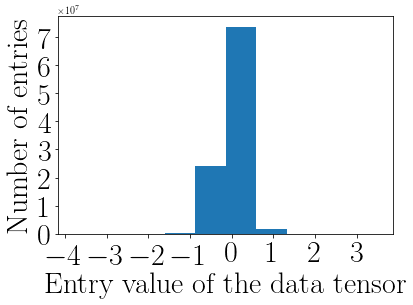

In [5]:
fontsize = 30
# ytick_pos = np.array([0, 2000, 4000, 6000, 8000])

plt.hist(X.flatten())
plt.ylabel("Number of entries", fontsize=fontsize)
plt.xlabel("Entry value of the data tensor", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)

(array([       0., 10000000., 20000000., 30000000., 40000000., 50000000.,
        60000000.]), <a list of 7 Text yticklabel objects>)

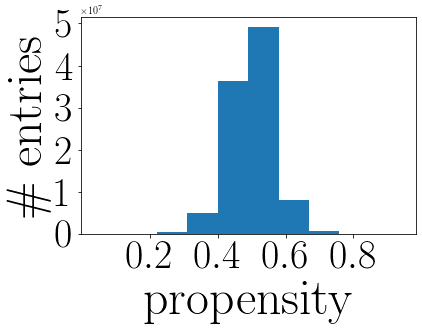

In [6]:
fontsize = 50
# ytick_pos = np.array([0, 2000, 4000, 6000, 8000])

plt.hist(P.flatten())
plt.ylabel("\# entries", fontsize=fontsize)
plt.xlabel("propensity", fontsize=fontsize)

xtick_pos = [0.2, 0.4, 0.6, 0.8]
plt.xticks(xtick_pos, fontsize=fontsize-10)
plt.yticks(fontsize=fontsize-10)

In [7]:
prop_B = std_logistic_function(A_true)
mask_B = (np.random.uniform(0, 1, prop_B.shape) < prop_B).astype(int)

estimate propensities - gradient descent

In [ ]:
target_ranks = [5, 5, 5, 5]
step_size = 5e-6
A_pred, optimization_details_1 = one_bit_TC_fully_observed_gd(
    mask_B, std_logistic_function, target_ranks, max_iter=100, A_true=A_true, 
    step_size_G=step_size, step_size_U=step_size)

In [ ]:
target_ranks = [5, 5, 5, 5]
step_size = 3e-6
A_pred_2, optimization_details_2 = one_bit_TC_fully_observed_gd(
    mask_X, std_logistic_function, target_ranks, max_iter=100, A_true=A_true, 
    step_size_G=step_size, step_size_U=step_size)

In [ ]:
target_ranks = [5, 5, 5, 5]
step_size = 1e-6
A_pred_3, optimization_details_3 = one_bit_TC_fully_observed_gd(
    mask_X, std_logistic_function, target_ranks, max_iter=100, A_true=A_true, 
    step_size_G=step_size, step_size_U=step_size)

In [ ]:
target_ranks = [5, 5, 5, 5]
step_size = 5e-7
A_pred_4, optimization_details_4 = one_bit_TC_fully_observed_gd(
    mask_X, std_logistic_function, target_ranks, max_iter=100, A_true=A_true, 
    step_size_G=step_size, step_size_U=step_size)

In [ ]:
target_ranks = [5, 5, 5, 5]
step_size = 7e-6
A_pred_5, optimization_details_5 = one_bit_TC_fully_observed_gd(
    mask_X, std_logistic_function, target_ranks, max_iter=100, A_true=A_true, 
    step_size_G=step_size, step_size_U=step_size)

In [ ]:
step_size_all = [5e-6, 3e-6, 1e-6, 5e-7, 7e-6]

def extract_optimization_details_all(iter):
    P_relative_error_all = []
    relative_loss_all = []
    for idx, step_size in enumerate(step_size_all):
        U_all = eval("optimization_details_{}".format(idx+1))['U'][iter].copy()
        G = eval("optimization_details_{}".format(idx+1))['G'][iter].copy()
    
        A_pred_single_iter = tucker_to_tensor((G, U_all))

        loss = tensor_log_loss(mask_B, A_pred_single_iter)
        relative_loss = loss / loss_true
        P_relative_error_all.append(normalized_error(std_logistic_function(A_true), 
                                                     std_logistic_function(A_pred_single_iter)))
        relative_loss_all.append(relative_loss)


    return iter, P_relative_error_all, relative_loss_all

In [ ]:
p1 = mp.Pool(100)
result = [p1.apply_async(extract_optimization_details_all, args=[iter]) for iter in range(100)]
p1.close()
p1.join()

result = [item.get() for item in result]
result = np.vstack(result)

In [ ]:
P_relative_error_all = np.vstack([np.array(result[i][1]) for i in range(100)])
relative_loss_all = np.vstack([np.array(result[i][2]) for i in range(100)])
P_relative_error_all[np.isnan(P_relative_error_all)] = 2
relative_loss_all[np.isnan(relative_loss_all)] = 10

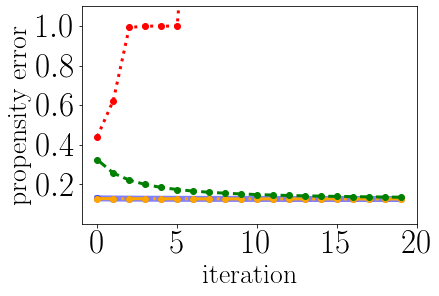

In [130]:
fontsize = 33
linewidth = 3
markersize = 6
n_iters = 20
colors = ['blue', 'green', 'orange', 'red']

plt.plot(np.arange(n_iters), P_relative_error_all[:n_iters, 4], 'bo', linestyle=':', linewidth=linewidth, markersize=markersize, color=colors[3], label=r"$7 \times 10^{-6}$")
plt.plot(np.arange(n_iters), P_relative_error_all[:n_iters, 0], 'bo', linestyle='-', linewidth=linewidth+3, alpha=0.5, markersize=markersize, color=colors[0], label=r"$5 \times 10^{-6}$")
plt.plot(np.arange(n_iters), P_relative_error_all[:n_iters, 1], 'bo', linestyle='-.', linewidth=linewidth, markersize=markersize, color=colors[2], label=r"$3 \times 10^{-6}$")
plt.plot(np.arange(n_iters), P_relative_error_all[:n_iters, 2], 'bo', linestyle='--', linewidth=linewidth, markersize=markersize, color=colors[1], label=r"$1 \times 10^{-6}$")

plt.ylabel("propensity error", fontsize=fontsize-5)
plt.xlabel("iteration", fontsize=fontsize-5)
xtick_pos = [0, 5, 10, 15, 20]
ytick_pos = [0.2, 0.4, 0.6, 0.8, 1]
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
plt.xticks(xtick_pos, fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)
plt.ylim(0, 1.1)

plt.legend(loc='upper center', bbox_to_anchor=(.75, 1.05), fancybox=True, shadow=True, ncol=1, fontsize=fontsize-10)

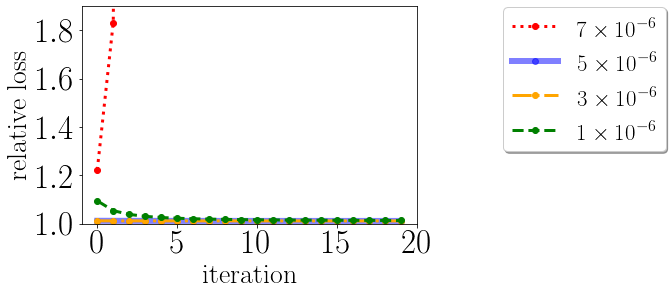

In [132]:
fontsize = 33
linewidth = 3
markersize = 6
n_iters = 20
colors = ['blue', 'green', 'orange', 'red']

plt.plot(np.arange(n_iters), relative_loss_all[:n_iters, 4], 'bo', linestyle=':', linewidth=linewidth, markersize=markersize, color=colors[3], label=r"$7 \times 10^{-6}$")
plt.plot(np.arange(n_iters), relative_loss_all[:n_iters, 0], 'bo', linestyle='-', linewidth=linewidth+3, alpha=0.5, markersize=markersize, color=colors[0], label=r"$5 \times 10^{-6}$")
plt.plot(np.arange(n_iters), relative_loss_all[:n_iters, 1], 'bo', linestyle='-.', linewidth=linewidth, markersize=markersize, color=colors[2], label=r"$3 \times 10^{-6}$")
plt.plot(np.arange(n_iters), relative_loss_all[:n_iters, 2], 'bo', linestyle='--', linewidth=linewidth, markersize=markersize, color=colors[1], label=r"$1 \times 10^{-6}$")

plt.ylabel("relative loss", fontsize=fontsize-5)
plt.xlabel("iteration", fontsize=fontsize-5)
xtick_pos = [0, 5, 10, 15, 20]
ytick_pos = [1, 1.2, 1.4, 1.6, 1.8]
plt.xticks(xtick_pos, fontsize=fontsize)
plt.yticks(ytick_pos, fontsize=fontsize)
plt.ylim(1, 1.9)

plt.legend(loc='upper center', bbox_to_anchor=(1.5, 1.05), fancybox=True, shadow=True, ncol=1, fontsize=fontsize-10)